<a href="https://colab.research.google.com/github/May-Moon-Colab/Business-Analytics/blob/main/Challenge%20Shelter%20Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CHALLENGE: Demand in NYC
Description:
 How many people need a shelter?
  1. Prepare dataframe
  2. Training and test set
  3. Create model and assess accuracy
  4. Visualize the output
  5. Perform parameter tuning

#Directory, Libraries and Data

In [75]:
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet


In [76]:
#import libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [77]:
#data
df = pd.read_csv("DHS_weekly.csv")
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143


In [78]:
#Date variable and rename date and Y
df.Date = pd.to_datetime(df.Date,
                         format = "%m/%d/%Y")
df = df.rename(columns = {'Date': 'ds',
                          'Total Individuals in Shelter': 'y'})
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848000
1,2014-01-12,358103,0,0,0,3.257143
2,2014-01-19,359491,0,0,0,5.632857
3,2014-01-26,362880,0,0,0,-1.850000
4,2014-02-02,364125,0,0,0,1.177143


#Holidays

In [79]:
#Easter
easter_dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                      'ds':easter_dates,
                      'lower_window': -7,
                      'upper_window': 7})
easter

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7
171,easter,2017-04-16,-7,7
221,easter,2018-04-01,-7,7
276,easter,2019-04-21,-7,7
327,easter,2020-04-12,-7,7


In [80]:
#Thanksgiving
thanksgiving_dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                      'ds':thanksgiving_dates,
                      'lower_window': -7,
                      'upper_window': 7})


In [81]:
#combine events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7
171,easter,2017-04-16,-7,7
221,easter,2018-04-01,-7,7
276,easter,2019-04-21,-7,7
327,easter,2020-04-12,-7,7
47,thanksgiving,2014-11-30,-7,7
99,thanksgiving,2015-11-29,-7,7
151,thanksgiving,2016-11-27,-7,7


In [82]:
#finish df -> remote duplicated holidays
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(2)

,ds,y,Christmas,Temperature
0,2014-01-05,354354,0,0.848000
1,2014-01-12,358103,0,3.257143


#Prophet Model

In [83]:
#training and test split
test_weeks = 4
training = df.iloc[:-4,:]
test = df.iloc[-4:, :]
test

,ds,y,Christmas,Temperature
362,2020-12-13,375820,0,8.208571
363,2020-12-20,375615,0,3.535714
364,2020-12-27,374203,1,7.510000
365,2021-01-03,212514,0,6.625000


In [84]:
#Prophet model
m = Prophet (growth = 'linear',
             yearly_seasonality= True,
             weekly_seasonality= False,
             holidays = holidays,
             seasonality_mode= "multiplicative",
             seasonality_prior_scale= 10,
             holidays_prior_scale= 10,
             changepoint_prior_scale= 0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmfove0j/hmn8wtmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmfove0j/w_nojnbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72889', 'data', 'file=/tmp/tmpbmfove0j/hmn8wtmz.json', 'init=/tmp/tmpbmfove0j/w_nojnbo.json', 'output', 'file=/tmp/tmpbmfove0j/prophet_modelts7svkz5/prophet_model-20230322030034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:00:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:00:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
#Coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.000000,-0.000174,-0.000174,-0.000174
1,Temperature,multiplicative,14.934939,-0.000237,-0.000237,-0.000237


#Forecasting

In [86]:
#Future dataframe
future = m.make_future_dataframe(periods= test_weeks,
                                 freq = "W")
future = pd.concat([future, df.iloc[:,2:]], axis = 1)
future.tail()

,ds,Christmas,Temperature
361,2020-12-06,0,10.072857
362,2020-12-13,0,8.208571
363,2020-12-20,0,3.535714
364,2020-12-27,1,7.510000
365,2021-01-03,0,6.625000


In [87]:
#forecasting
forecast = m.predict(future)

In [88]:
#Holidays
holiday = 'thanksgiving'
forecast[(forecast[holiday].abs()> 0) & (forecast['ds']> '2020-01-01')][
    ['ds', holiday]]

,ds,thanksgiving
359,2020-11-22,0.002152
360,2020-11-29,-0.001041
361,2020-12-06,-0.004004


In [89]:
#retrieve the predictions
predictions = forecast.yhat[-test_weeks:]
predictions

362    385723.083731
363    384828.176469
364    382595.402982
365    381521.863467
Name: yhat, dtype: float64

In [90]:
#accuracy assessment
np.sqrt(mean_squared_error(test['y'], predictions))

84877.91825558706

#Visualization

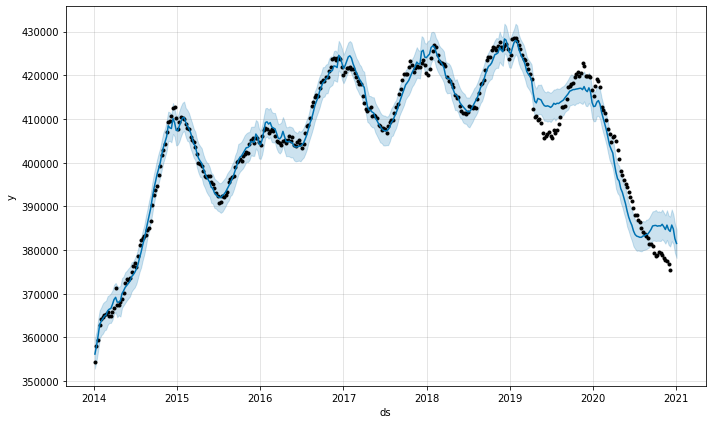

In [91]:
#Plot forecast
m.plot(forecast);

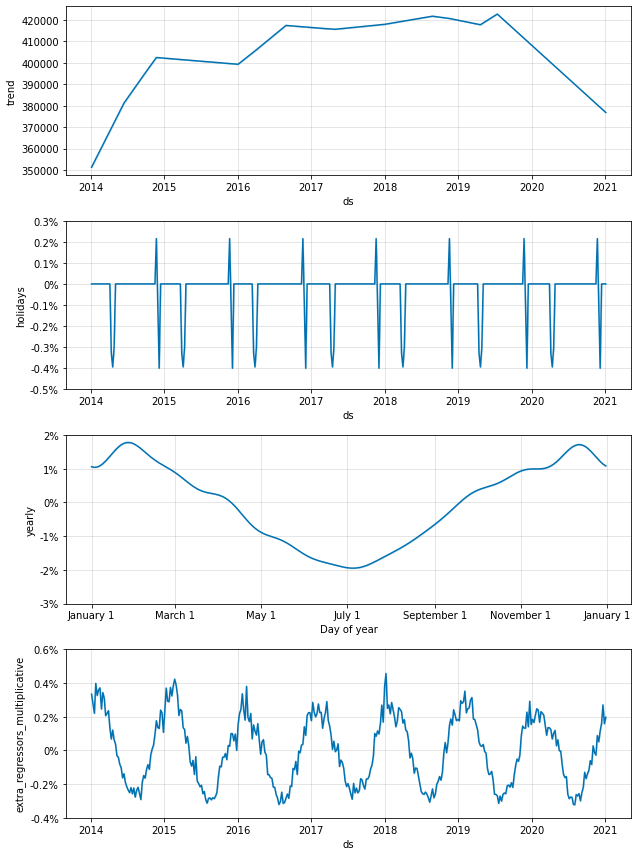

In [92]:
#model components
m.plot_components(forecast);

#Cross - Validation

In [93]:
df.shape

(366, 4)

In [71]:
df_cv = cross_validation(m,
                         horizon = "4 W", #28days also possible
                         initial = "300 W", #1500 days
                         parallel = 'processes')
df_cv

INFO:prophet:Making 29 forecasts with cutoffs between 2019-10-13 00:00:00 and 2020-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f413d1b2730>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmfove0j/l8ublayd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmfove0j/3u670vpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmfove0j/549wpz05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbmfove0j/sohxmxf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89852', 'data', 'file=/tmp/tmpbmfove0j/3u670vpb.json', 'init=/tmp/tmpbmfove0j/549wpz05.json', 'output', 'file=/tmp/tmpbmfove0j/prophet_modelef5cqbga/prophet_model-20230322030015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args:

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,419468.686329,418226.579307,420789.078564,420265,2019-10-13
1,2019-10-27,420190.088009,418829.818514,421531.308640,420670,2019-10-13
2,2019-11-03,420758.797424,419444.408207,422088.566552,419924,2019-10-13
3,2019-11-10,420947.433408,419443.687709,422337.424687,420624,2019-10-13
4,2019-11-03,420750.023030,419465.267890,422114.942680,419924,2019-10-27
...,...,...,...,...,...,...
111,2020-11-22,392536.897793,388892.987048,396035.377498,377413,2020-10-25
112,2020-11-15,389089.528491,385518.662092,392549.327004,377700,2020-11-08
113,2020-11-22,390579.448396,387298.616181,394072.208782,377413,2020-11-08
114,2020-11-29,389633.218727,386187.216320,393176.152183,376769,2020-11-08


In [72]:
#CV output
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,419468.686329,418226.579307,420789.078564,420265,2019-10-13
1,2019-10-27,420190.088009,418829.818514,421531.308640,420670,2019-10-13
2,2019-11-03,420758.797424,419444.408207,422088.566552,419924,2019-10-13
3,2019-11-10,420947.433408,419443.687709,422337.424687,420624,2019-10-13
4,2019-11-03,420750.023030,419465.267890,422114.942680,419924,2019-10-27
...,...,...,...,...,...,...
111,2020-11-22,392536.897793,388892.987048,396035.377498,377413,2020-10-25
112,2020-11-15,389089.528491,385518.662092,392549.327004,377700,2020-11-08
113,2020-11-22,390579.448396,387298.616181,394072.208782,377413,2020-11-08
114,2020-11-29,389633.218727,386187.216320,393176.152183,376769,2020-11-08


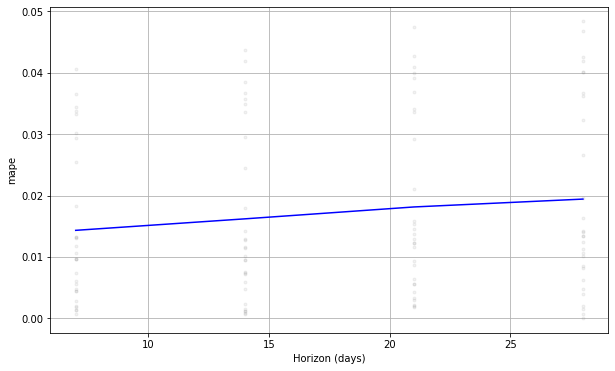

In [73]:
#CV visualization
plot_cross_validation_metric(df_cv, metric = "mape");

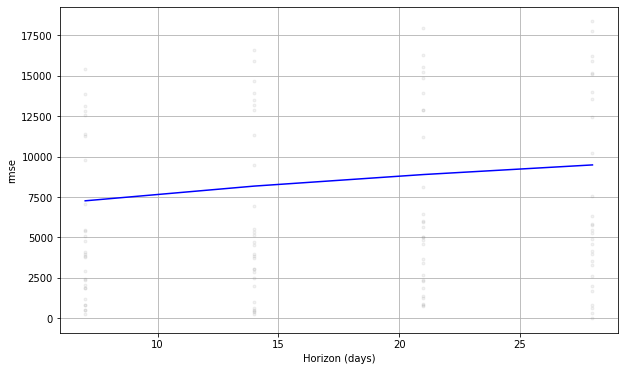

In [74]:
#CV visualization
plot_cross_validation_metric(df_cv, metric = "rmse"); #the error increasing

#Parameter Tuning

In [94]:
#parameter Grid
param_grid = {'seasonality_mode': [ 'additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

54

In [ ]:
#parameter list
rmse = []
#loop
for params in grid:
  #build the model
  m = Prophet (growth = 'linear',
             yearly_seasonality= True,
             weekly_seasonality= False,
             holidays = holidays,
             seasonality_mode= params['seasonality_mode'],
             seasonality_prior_scale= params['seasonality_prior_scale'],
             holidays_prior_scale= params['holidays_prior_scale'],
             changepoint_prior_scale= params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.add_regressor('Temperature')
  m.fit(training)

  #CV
  df_cv = cross_validation(m,
                         horizon = "4 W", #28days also possible
                         initial = "300 W", #1500 days
                         parallel = 'processes')
  
  #Measure and store the error
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)

In [96]:
#get the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,9096.759986
1,0.01,5,additive,10,9137.407202
2,0.01,5,additive,20,9043.545469
3,0.01,5,multiplicative,5,8972.147513
4,0.01,5,multiplicative,10,8945.606504
5,0.01,5,multiplicative,20,8961.118792
6,0.01,10,additive,5,9109.331030
7,0.01,10,additive,10,9038.594110
8,0.01,10,additive,20,9069.679149
9,0.01,10,multiplicative,5,8974.057144
